# Amazon Review Helpfulness Prediction 

## Problem Statement:
In this project, we are tring to address the bias associated with the amazon review helpfulness which is currently ranked based on the number of upvotes the review received. We will use machine learning techniques to design a model which will predict or classify the review whether it is helpful or not helpful.The final outcome of the project is how well we are able to predict the new review as helpful or not helpful.

For the problem statement, we will use the Home and Kitchen dataset which is having around 346,355 reviews. Dataset is available at JmCauley page: http://jmcauley.ucsd.edu/data/amazon/links.html

## Data Analysis

In [1]:
# Importing the relevant dependencies
import numpy as np
import pandas as pd
import gzip
import math, time, random, datetime
import string
import nltk
nltk.download('stopwords')

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from IPython.display import display # Allows the use of display() for DataFrames

In [2]:
import os
# Loading the home and kitchen dataset which is downloaded in the /data path
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i +=1
    return pd.DataFrame.from_dict(df, orient='index')

data = getDF('../data/raw/reviews_Home_and_Kitchen_5.json.gz')    

In [3]:
# Lets look at the data
data.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,1312416000,"08 4, 2011"
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,1402099200,"06 7, 2014"


As mentioned in the jmcauley site, belaw are the description of the fields:
1. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
2. asin - ID of the product, e.g. 0000013714
3. reviewerName - name of the reviewer
4. helpful - helpfulness rating of the review, e.g. 2/3.
5. reviewText - text of the review
6. overall - rating of the product
7. summary - summary of the review
8. unixReviewTime - time of the review (unix time)
9. reviewTime - time of the review (raw)


As per the problem statement of the project, lets extract the useful information needed:
1. 'reviewText' which will be used to generate the features
2. 'helpful'. As it is an array of helpful_ratings and total ratings . We will split them and predict the helpful ratings and use it as target labels.
3. 'overall' as one of the feature. We will see if there is any correlation between overall and helpful_ratings and check if it can help in improving the performance of the model.
4. 'unixReviewTime. In case if we would like to give importance to review based on review date, preferring new review over old review.

In [4]:
# Extracting the useful columns from the data
df = data.loc[:, ['helpful', 'reviewText', 'overall', 'unixReviewTime']]

# Split the helpful into helpful_ratings and total_ratings
df['helpful_ratings'] = df['helpful'].apply(lambda x: x[0])
df['total_ratings'] = df['helpful'].apply(lambda x: x[1])

# Delete helpful from df
del df['helpful']

# Convert unixReviewTimestamp to date format 'YYYY-MM-DD'
df['reviewDate'] = df['unixReviewTime'].apply(lambda x : datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))
df['reviewYear'] = pd.DatetimeIndex(df['reviewDate']).year

# Delete unixReviewtime from df
del df['unixReviewTime']

# Check if there is any null values
print(df.isnull().sum())

reviewText         0
overall            0
helpful_ratings    0
total_ratings      0
reviewDate         0
reviewYear         0
dtype: int64


In [5]:
# Check the df statistics
df.describe()

,overall,helpful_ratings,total_ratings,reviewYear
count,551682.000000,551682.000000,551682.000000,551682.000000
mean,4.316655,3.497348,3.939469,2012.272922
std,1.110749,76.539142,77.801556,1.979143
min,1.000000,0.000000,0.000000,2000.000000
25%,4.000000,0.000000,0.000000,2012.000000
50%,5.000000,0.000000,0.000000,2013.000000
75%,5.000000,1.000000,2.000000,2014.000000
max,5.000000,52176.000000,52861.000000,2014.000000


There is clearly some outliers in the data as there is huge difference between max and min value of helpful_ratings and total_ratings. Lets move to exploratory visualization for finding some insights on this.

## Exploratory Visualization 

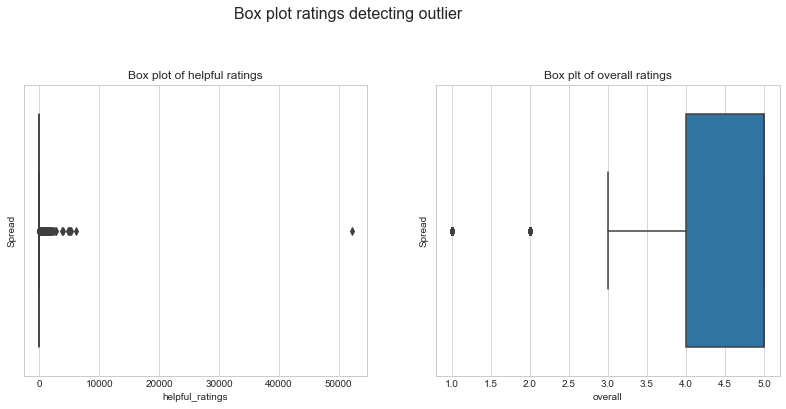

In [6]:
### Box Plot
plt.subplots(1,2, figsize=(15,6))

plt.subplot(121)
plt.title('Box plot of helpful ratings')
plt.xlabel('Helpful ratings')
plt.ylabel('Spread')
sns.boxplot(x=df['helpful_ratings'])

plt.subplot(122)
plt.title('Box plt of overall ratings')
plt.xlabel('overall ratings')
plt.ylabel('Spread')
sns.boxplot(x=df['overall'])

plt.suptitle('Box plot ratings detecting outlier', fontsize=16)

plt.subplots_adjust(left=0.2, wspace=0.2, top=0.8)
plt.show()

In [7]:
#df[df.helpful_ratings > 50000]
print(df['helpful_ratings'].idxmax(axis=0, skipna=True))
print(df['total_ratings'].idxmax(axis=0, skipna=True))

396128
396128


In [8]:
df.iloc[[396128]]

,reviewText,overall,helpful_ratings,total_ratings,reviewDate,reviewYear
396128,For decades I have been trying to come up with...,5.0,52176,52861,2011-03-03,2011


The reviewText looks fine. And we can ignore the extreme of helpful/total ratings as we are going to label the helpful ratings based on certain threshold.

In [9]:
df[df.overall == 1].count()

reviewText         27106
overall            27106
helpful_ratings    27106
total_ratings      27106
reviewDate         27106
reviewYear         27106
dtype: int64

In [10]:
df[df.overall == 2].count()

reviewText         24313
overall            24313
helpful_ratings    24313
total_ratings      24313
reviewDate         24313
reviewYear         24313
dtype: int64

The count of "overall" ratings of 1 and 3 is around 25000, we can't drop these rows as we might loose some important information.

## Data Preprocessing 

Lets first create the target label that is "helpful" based on the certain threshold say 0.50. If (helpful_ratings/total_ratings) > 0.50, then the review is helpful, else not helpful.
For achieving this we have to consider the review whose total_ratings is greater than 0. Lets keep the reviews with total_ratings as 0 into a separate dataframe, this data can be used in future for unsupervised learning of helpfulness prediction of unseen data.
 

In [11]:
# Separing the data with total_ratings as 0. Use this data for unsupervised learning in future
df1 = df[(df.total_ratings == 0)].copy()
df1.head(5)

,reviewText,overall,helpful_ratings,total_ratings,reviewDate,reviewYear
0,My daughter wanted this book and the price on ...,5.0,0,0,2013-10-19,2013
1,I bought this zoku quick pop for my daughterr ...,5.0,0,0,2014-06-18,2014
4,This cookbook is great. I have really enjoyed...,4.0,0,0,2014-06-07,2014
5,If you have a Zoku Quick Pop maker (or two.......,5.0,0,0,2014-06-07,2014
9,High quality book. Clear and helpful informati...,5.0,0,0,2014-06-01,2014


In [12]:
# Use data with total_ratings > 0 for creating target label "helpful"
df2 = df[(df.total_ratings > 0)].copy()
df2.shape

(248634, 6)

In [13]:
# Transform helpfulness as a binary feature with threshold of 0.50
threshold=0.5
df2.loc[:, 'Helpful'] = np.where(df2.loc[:, 'helpful_ratings']/df2.loc[:, 'total_ratings'] > threshold, 1, 0)
df2.head(5)

,reviewText,overall,helpful_ratings,total_ratings,reviewDate,reviewYear,Helpful
2,There is no shortage of pop recipes available ...,4.0,26,27,2013-05-05,2013,1
3,This book is a must have if you get a Zoku (wh...,5.0,14,18,2011-08-04,2011,1
6,This book is so beautifully illustrated and ea...,5.0,2,3,2012-07-02,2012,1
7,I bought this when I bought the pop maker. I t...,2.0,32,39,2011-12-08,2011,1
8,"The Zoku accessories are pricey, but the recip...",5.0,13,13,2011-09-22,2011,1


In [14]:
# Check the distribution of helpful and non-helpful reviews
display(df2.groupby('Helpful').count())

,reviewText,overall,helpful_ratings,total_ratings,reviewDate,reviewYear
Helpful,,,,,,
0,45529,45529,45529,45529,45529,45529
1,203105,203105,203105,203105,203105,203105


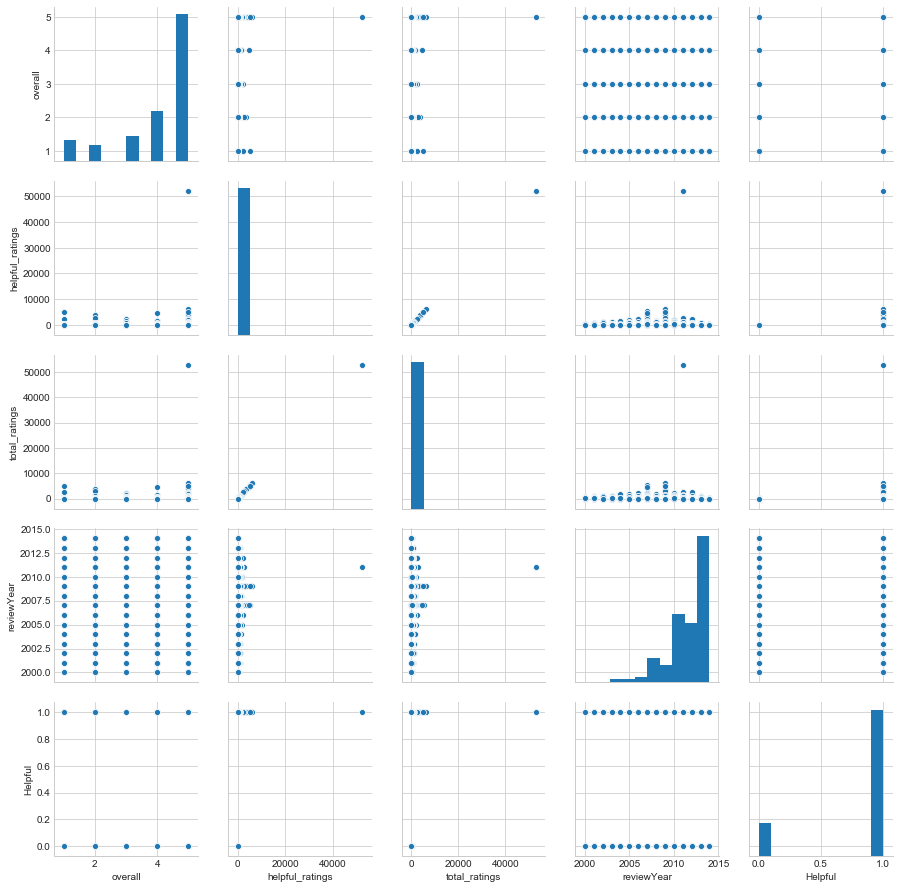

In [15]:
# Pairplot Visualization
sns.pairplot(df2)

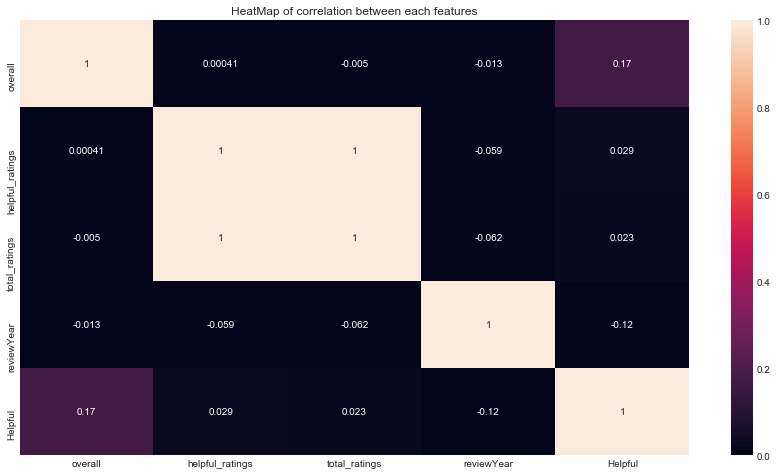

In [16]:
# Visualizing correlation of the data
correlations = df2.corr()
plt.figure(figsize=(15,8))
plt.title('HeatMap of correlation between each features')
_ = sns.heatmap(correlations, vmin=0, vmax=1, annot=True)

With these distribution, it is clear that our dataset is unbalanced, with roughly around 7 to 8 times as many helpful reviews as compared to not helpful reviews. For proper distribution of both category of data, we will use StratifiedShuffle while splitting the train test data.

There is very small correlation between overall score and helpful. As this correlation is small, we have to generate reviewText feature generaion for predicting the review helpfulness.

Lets create a uniform/balanced dataset of around 1000000 from df2 dataframe which is basically the dataset where we have ignored the unlabelled i.e where total ratings as 0

In [17]:
df3 =df2[(df2.Helpful == 1)].sample(frac=.25).reset_index(drop=True).copy()
df3 = df3.append(df2[(df2.Helpful == 0)], ignore_index=True)
df3.head()

,reviewText,overall,helpful_ratings,total_ratings,reviewDate,reviewYear,Helpful
0,This in wall ironing board mount is exactly wh...,5.0,4,6,2012-11-28,2012,1
1,I've had this scale a couple of weeks now and ...,5.0,58,63,2012-03-28,2012,1
2,This is a great box to store celery and it kee...,4.0,2,3,2012-04-27,2012,1
3,I just got this unit and am pleased with it so...,5.0,3,4,2012-05-23,2012,1
4,I loved this!!! We got it based on a family re...,3.0,8,9,2007-10-30,2007,1


In [18]:
# Check the distribution of helpful and non-helpful reviews
display(df3.groupby('Helpful').count())

,reviewText,overall,helpful_ratings,total_ratings,reviewDate,reviewYear
Helpful,,,,,,
0,45529,45529,45529,45529,45529,45529
1,50776,50776,50776,50776,50776,50776


We created a uniform distributed sets in which we can apply our models

#### Review Text Feature Generation

For generating the text feature, we will use below text preprocessing steps which is common while handling text data:
1. Tokenization: convert sentences to words
2. Removing unnecessary punctuation words, tags, etc
3. Removing stop words: frequent words such as "the", "if", "is" that doesnot have specific semantic
4. Stemming: words are reduced to a root by removing the inflection by dropping unnecessary characters usually a suffix
5. Lemmatization: Another approach to remove inflection by determining the part of speech and utilizing detailed database of the language.

I want to experiment on traditional and deep learning way of approach for handling the text features.
For traditional approach, I would use TF-IDF(Term Frequency-Inverse Document Frequency) approach
One with Unsupervised learning approach, maybe Glove or Skip-n grams approach we will decide.

Let's first start with TF-IDF approach of word embeddings.

#### TF-IDF 

This approach of word embeddings is based on frequency method. It takes into account not just the occurrence of a word in a single document but in the entire corpus.
TF-IDF works by penalising the common words occurring across the documents by weighing down the common words that occur in almost every document (e.g. “the” or “a”) and give more importance to those that appear only in a few documents.

In detail, TF IDF is composed of two parts: TF which is the term frequency of a word, i.e. the count of the word occurring in a document and IDF, which is the inverse document frequency, i.e. the weight component that gives higher weight to words occuring in only a few documents.

Mathematically, we can define TF-IDF as tfidf = tf x idf, which can be expanded further to be represented as follows.

tfidf(w,D) = tf(w,D)* idf(w,D) = tf(w,D) * log(C/df(w))

Here, tfidf(w, D) is the TF-IDF score for word w in document D. The term tf(w, D) represents the term frequency of the word w in document D, which can be obtained from the Bag of Words model. The term idf(w, D) is the inverse document frequency for the term w, which can be computed as the log transform of the total number of documents in the corpus C divided by the document frequency of the word w, which is basically the frequency of documents in the corpus where the word w occurs.

For generating the etxt features we will use Tfidf vetorizer from scikit learn and NLTK library for text preprocessing.

Let's convert the text into lower case to run natural language processing for producing features.We will also remove punctuation. Removing punctuation may seem like it should not be done in the case of this problem, as not having punctuation will make a review harder to understand. This is a trade-off that we must consider. If we include punctuation, it will cause the learning algorithm to behave poorly.

In [19]:
import re
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_text(text):
    # lower case and remove special characters\whitespaces
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    # tokenize document
    tokens = wpt.tokenize(text)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    text = ' '.join(filtered_tokens)
    return text

#normalize_corpus = np.vectorize(normalize_document)
df3['reviewText'] = df3['reviewText'].apply(lambda x: normalize_text(x))
df3['reviewText'].head()

0    wall ironing board mount exactly advertised ri...
1    ive scale couple weeks happy thin enough fit s...
2    great box store celery keeps nice crisp fridge...
3    got unit pleased far set almost closed sliding...
4    loved got based family recommendation worked c...
Name: reviewText, dtype: object

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Defining the Tfidf vectorizer
vectorizer = TfidfVectorizer(min_df=0.01, max_df=1., ngram_range=(1, 1))
#fit the vectorizers to the data.
features = vectorizer.fit_transform(df3['reviewText'])
features

<96305x941 sparse matrix of type '<class 'numpy.float64'>'
	with 3051059 stored elements in Compressed Sparse Row format>

In [21]:
def extract_topn_from_vector(feature_names, sorted_items, topn=5):
    """
      get the feature names and tf-idf score of top n items in the doc,                 
      in descending order of scores. 
    """

    # use only top n items from vector.
    sorted_items = sorted_items[:topn]

    results= {} 
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        results[feature_names[idx]] = round(score, 3)

    # return a sorted list of tuples with feature name and tf-idf score as its element(in descending order of tf-idf scores).
    return sorted(results.items(), key=lambda kv: kv[1], reverse=True)

feature_names = vectorizer.get_feature_names()
coo_matrix = features.tocoo()
tuples = zip(coo_matrix.col, coo_matrix.data)
sorted_items = sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

# extract only the top n elements.
# Here, n is 10.
word_tfidf = extract_topn_from_vector(feature_names, sorted_items, 15)

print("{}  {}".format("features", "tfidf"))  
for k in word_tfidf:
    print("{} - {}".format(k[0], k[1])) 

features  tfidf
yes - 1.0
wash - 1.0
try - 1.0
thats - 1.0
take - 1.0
super - 1.0
soft - 1.0
small - 1.0
short - 1.0
set - 1.0
says - 1.0
recommended - 1.0
power - 1.0
perfect - 1.0
oxo - 1.0


We have  generated all our features that we are going to use.

## Baseline Model 

A model that is quick and often used for text classification is GaussianNB, We will use this as quick way to get a benchmark ROC_AUC score for the project.

ROC Curve(Receiver Operating Characteristics) curve is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0.

The true positive rate is calculated as the number of true positives divided by the sum of the number of true positives and the number of false negatives. It describes how good the model is at predicting the positive class when the actual outcome is positive. This is also referred as sensitivity.
True Positive Rate = True Positives / (True Positives + False Negatives)

The false positive rate is calculated as the number of false positives divided by the sum of the number of false positives and the number of true negatives.

It is also called the false alarm rate as it summarizes how often a positive class is predicted when the actual outcome is negative.

False Positive Rate = False Positives / (False Positives + True Negatives)

The false positive rate is also referred to as the inverted specificity where specificity is the total number of true negatives divided by the sum of the number of true negatives and false positives.

Specificity = True Negatives / (True Negatives + False Positives)
Where False Positive Rate = 1 - Specificity

The ROC curve is a useful tool for a few reasons:

The curves of different models can be compared directly in general or for different thresholds.
The area under the curve (AUC) can be used as a summary of the model skill.
The shape of the curve contains a lot of information, including what we might care about most for a problem, the expected false positive rate, and the false negative rate.

To make this clear:

- Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
- Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.


For this purpose, we will split the data into 80% training and 20% testing. The benefit to splitting the data into testing and training sets is that this allows simulated evaluation of how well the model is performing before using it in the real world to make predictions.If there was no testing set, there would be no way of realistically evaluating the model as you would only be able to measure it's performace on data to which it's already been exposed. This will result in a false sense of confidence in how well the model performs.

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

def train_classifier(clf, X_train, y_train):
    ''' Fit a classifier to the training data'''
    #clf = GaussianNB()
    # Check the timings for training the classifier
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    
    # Print the results
    print('Trained model in {:4f} seconds'.format(end - start))

def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on roc_auc score '''
    # Check the timings for making predictions
    start = time.time()
    probas = clf.predict_proba(features)
    end = time.time()
    
    # Print and return the results
    print('Predictions in {:4f} seconds'.format(end - start))
    return roc_auc_score(target.values, probas[:,1].T)

def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifier based on roc_auc score. '''
    
    # Indicate the classifier and training set size
    print('Training a {} using a training set size of {}'.format(clf.__class__.__name__, X_train.shape[0]))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of predictcion for both the training and testing
    print('ROC_AUC score for training set: {:4f}'.format(predict_labels(clf, X_train, y_train)))
    print('ROC_AUC score for test set: {:4f}'.format(predict_labels(clf, X_test, y_test)))

def clf_test_roc_score(clf, X_train, y_train, X_test, y_test):
    ''''''
    clf.fit(X_train, y_train)
    probas = probas =clf.predict_proba(X_test)
    return roc_auc_score(y_test, probas[:,1].T)

Now lets train and predict using our benchmark model.

In [23]:
# split the datasets into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, df3['Helpful'], test_size=0.2, random_state=42)

# densify sparse matrices
x_tr = X_train.toarray()
x_te = X_test.toarray()

# Train and predict
#train_predict(gnb, X_train, y_train, X_test, y_test)
train_predict(GaussianNB(), x_tr, y_train, x_te, y_test)

Training a GaussianNB using a training set size of 77044
Trained model in 2.224716 seconds
Predictions in 3.318558 seconds
ROC_AUC score for training set: 0.628120
Predictions in 0.856277 seconds
ROC_AUC score for test set: 0.611177


ROC_AUC score is not that great. We will look at improving this score